In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

TFile *file = TFile::Open("ttbar_8TeV.root"); 

TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

In [2]:
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_MV1[10];

tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_MV1);

//----------Event weight
float evtw = 1; //tree->SetBranchAddress("mcWeight", &evtw);
float mcevtw = 1; tree->SetBranchAddress("mcWeight", &mcevtw);

In [3]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);

TH1F *hist_lep_pt = new TH1F("Lepton pT","Lepton pT; pT(GeV);Events",50,10,200);

In [4]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();
int cut1 = 0; int cut2 = 0; int cut3 = 0; int cut4 = 0; int cut5 = 0; int cut6 = 0; int cut7 = 0; int cut8 = 0;

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
        
    // Preselection of good leptons                                                                                
    int n_lep=0;
    
    //Loop over leptons
    for(unsigned int j=0; j<lep_n; j++){
        int n_mu=0; int n_el=0;
        
        if( lep_pt[j] < 25000.) continue; 
        if( lep_ptcone30[j]/lep_pt[j] > 0.15 ) continue; 
        if( lep_etcone20[j]/lep_pt[j] > 0.15 ) continue;  
        if( lep_type [j]==13 && TMath::Abs(lep_eta[j]) < 2.5 ){
            n_mu++;}
        /*
        To complete: Add electrons and extract the index for the good lepton
        */
        if( lep_type [j]==11 && ( (TMath::Abs(lep_eta[j]) < 2.47 && TMath::Abs(lep_eta[j]) > 1.52)
                                  ||
                                  (TMath::Abs(lep_eta[j]) < 1.37)) ){
            n_el++;}
        if(n_mu == 0 && n_el == 0) continue;
        n_lep++;
        }
    
     //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
  
    
    int n_jets=0;
    int n_bjets=0;
    
    //Number of jets distribution
    hist_njets->Fill(jet_n,evtw);

    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;
    
    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] < 25000) continue;
        //Eta cut
        if(jet_eta[j] > 2.5) continue;
        // JVF cleaning    
        if(jet_pt[j] < 50000 && TMath::Abs(jet_eta[j]) < 2.4) {
            if(jet_jvf[j] < 0.5) continue;}
        n_jets++;
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j] < 0.7892) continue;
        n_bjets++;
        }
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    
    //Sixth cut: at least two b-jets
    if(n_bjets<2) continue;
    cutflow->Fill(6); 
    cut6++;
        
    //Seventh cut: MET > 30 GeV
    if(MET<30000.) continue;
    cutflow->Fill(7); 
    cut7++;
    
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    //MeT.SetPtEtaPhiE(lep_pt[0],lep_eta[0],MET_phi,MET);
    //MeT.SetPtEtaPhiE(lep_pt[0],0,MET_phi,MET);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    
    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    //Eight cut: mTW > 30 GeV
    if(mTW <= 30000.) continue;
    cutflow->Fill(8); 
    cut8++;
    
    hist_lep_pt->Fill(lep_pt[0]/1000,evtw);
}

std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

All events:1500000
Cut1:1499487
Cut2:1499487
Cut3:1336214
Cut4:623273
Cut5:622125
Cut6:259904
Cut7:214514
Cut8:180970


<p>Draw</p>

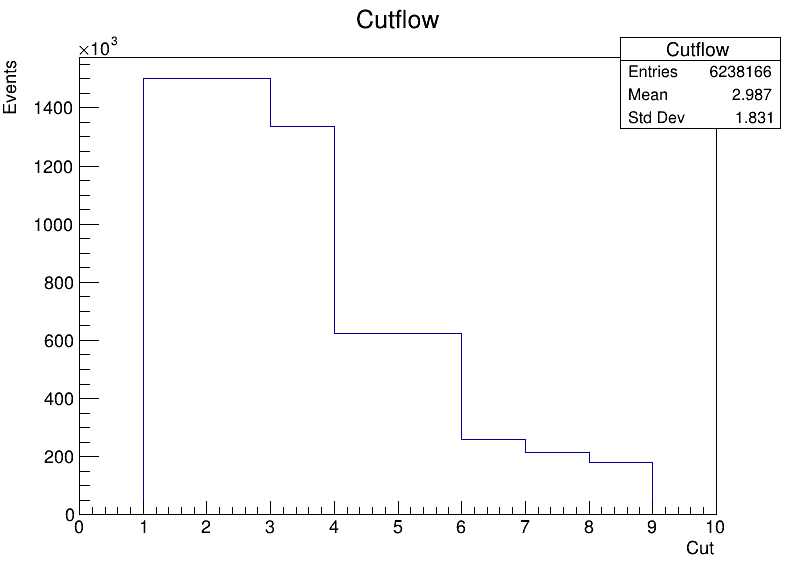

In [6]:
cutflow->Draw("");
canvas->Draw();

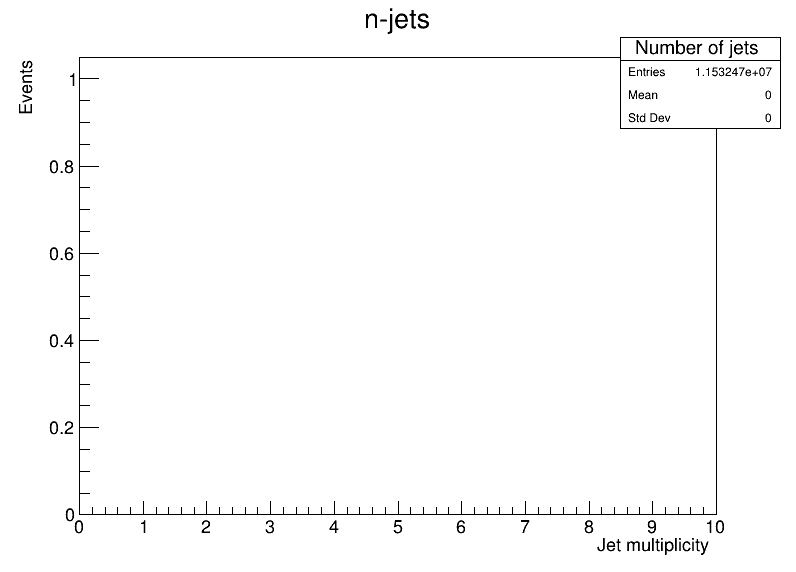

In [6]:
hist_njets->Draw();
canvas->Draw();

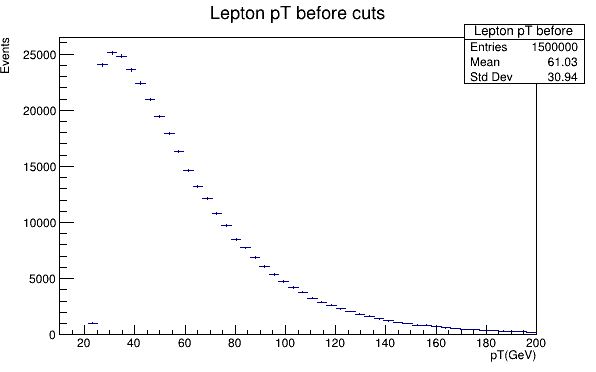

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


In [5]:
TH1F *hist_lep_pt_before = new TH1F("Lepton pT before","Lepton pT before cuts; pT(GeV);Events",50,10,200);

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   
    hist_lep_pt_before->Fill(lep_pt[0]/1000,evtw);     
}

TCanvas *canvas = new TCanvas("Canvas","",600,400);
// hist_lep_pt_before->SetMarkerStyle(20);
// hist_lep_pt_before->SetMarkerColor(kRed);
hist_lep_pt_before->Draw("");
//canvas->SetLogy();
canvas->Draw();

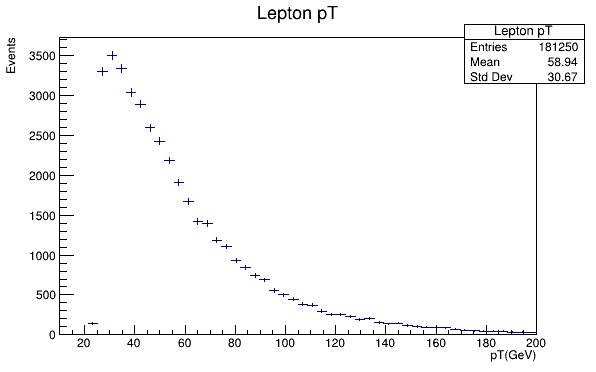

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


In [11]:
TCanvas *canvas = new TCanvas("Canvas","",600,400);

hist_lep_pt->Draw("");
//canvas->SetLogy();
canvas->Draw();

In [9]:

for (i = 0; i < 10; i++)
{
    nbytes = tree->GetEntry(i);   
    std::cout<< lep_n << std::endl;     
}


1
1
2
1
1
1
1
1
1
1
